In [ ]:
import pandas as pd           
import praw                   
import re                     
import datetime as dt
import seaborn as sns
import requests
import json
import sys
import time

'''

notes:

- traffic = reddit.subreddit(subreddit).traffic() is not available to us, sadly.

'''

'''

## acknowledgements

https://stackoverflow.com/questions/48358837/pulling-reddit-comments-using-python-praw-and-creating-a-dataframe-with-the-resu
https://www.reddit.com/r/redditdev/comments/2e2q2l/praw_downvote_count_always_zero/
https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

For navigating pushshift: https://github.com/Watchful1/Sketchpad/blob/master/postDownloader.py

'''

with open("API.env") as file:
    exec(file.read())

reddit = praw.Reddit(
  client_id = client_id,
  client_secret = client_secret,
  user_agent = user_agent
)


subreddit_df = pd.DataFrame()


In [348]:
'''
Some helper functions for the reddit API.
'''

def extract_num_rewards(awardings_data):
    return sum( x["count"] for x in awardings_data)


def extract_data(submission, comments = True):
    postlist = []

    content = {
    "title" : submission.title,
    "self" : submission.is_self,
    #"text" : submission.selftext,
    #"comments" : postlist,
    "author" : submission.author,
    "name" : submission.name,
    "id" : submission.id,
    "upvote_ratio" : submission.upvote_ratio,
    "ups" : submission.score, #this is the same as submission.ups,
    "downs" : None,
    "awarders" : submission.awarders, 
    "awards" : submission.all_awardings,
    "total_awards" : None,
    "url" : submission.url # Only relevent if not a self post
    }
    
    content["total_awards"] = extract_num_rewards(content["awards"])
    content["downs"] = (1 - content["upvote_ratio"]) * content["ups"] / content["upvote_ratio"]
    return content

In [ ]:
'''
Code for getting all submissions between certain date time
'''

def convert_to_utc(date):
    return int(date.replace(tzinfo=dt.timezone.utc).timestamp())

def get_all_submissions(start_time, end_time, subreddit):
    end = end_time
    df = pd.DataFrame()
    while end > start_time:
        time.sleep(1) # Requests are rate limited
        print(f"Target time: {start_time}, current end point {end}, remaining {end - start_time}")

        url = f"https://api.pushshift.io/reddit/submission/search/?after={start_time}&before={end}&sort_type=created_utc&sort=desc&subreddit={subreddit}&limit=1000"

        data = requests.get(url)
        
        
        if data.headers['Content-Type'] == 'application/json; charset=UTF-8':
            data_json = data.json()
            if len(data_json['data']) == 0:
                # break if there is no returned data
                break

            temp_df = pd.DataFrame(data_json['data'])
            end = min(temp_df.created_utc) 
            df = df.append(temp_df, ignore_index = True)
        else:
            print(data.headers['Content-Type']) 
            
    # Get the current score from praw
    print(f"pushshift found {len(df)} submissions.")
    print("Getting the updated values.")

    scores = []
    total_awards_received = []
    ratios = []

    # Based on this: https://www.reddit.com/r/redditdev/comments/aoe4pk/praw_getting_multiple_submissions_using_by_id/
    ids2 = [i if i.startswith('t3_') else f't3_{i}' for i in list(df.id)]

    
    # Because there are some days that pushshift disagrees with praw, I changed the code to just get the submissions 
    # ids from pushshift, and then to download the data from PRAW.
    praw_submissions = []
    for submission in reddit.info(ids2): # Makes a single call to the PRAW API, much faster than doing them one by one.
        praw_submissions.append(extract_data(submission))
    
    praw_df = pd.DataFrame(praw_submissions)
    print(f"PRAW found {len(praw_df)} submissions.")
    return praw_df

new_start = True #False for picking up where it was left off
if new_start == True:
    start = dt.datetime(2021, 1,26)
    end = dt.datetime(2021, 5, 7) #dt.datetime.now()
    delta = dt.timedelta(days=1)
    window_left = start
    
    window_right = start + delta

while window_right < end:
    # Decided to go day by day to avoid losing data due to crashing partway through
    print(f"Processing {window_left} to {window_right}")
    
    start_time = convert_to_utc(window_left)
    end_time = convert_to_utc(window_right)
    df = get_all_submissions(start_time, end_time, "wallstreetbets")
    df.to_pickle(f"Data/wsb_start{convert_to_utc(window_left)}.pkl")
    subreddit_df = subreddit_df.append(df, ignore_index = True)
    window_left += delta
    window_right += delta

subreddit_df.to_pickle("Data/2021wsb.pkl")

Processing 2021-01-26 00:00:00 to 2021-01-27 00:00:00
Target time: 1611619200, current end point 1611705600, remaining 86400
Target time: 1611619200, current end point 1611678188, remaining 58988
Target time: 1611619200, current end point 1611677792, remaining 58592
Target time: 1611619200, current end point 1611677359, remaining 58159
Target time: 1611619200, current end point 1611676920, remaining 57720
Target time: 1611619200, current end point 1611676525, remaining 57325
Target time: 1611619200, current end point 1611676183, remaining 56983
Target time: 1611619200, current end point 1611675861, remaining 56661
Target time: 1611619200, current end point 1611675604, remaining 56404
Target time: 1611619200, current end point 1611675391, remaining 56191
Target time: 1611619200, current end point 1611675136, remaining 55936
Target time: 1611619200, current end point 1611674783, remaining 55583
Target time: 1611619200, current end point 1611674466, remaining 55266
Target time: 1611619200

Target time: 1611705600, current end point 1611788357, remaining 82757
Target time: 1611705600, current end point 1611788279, remaining 82679
Target time: 1611705600, current end point 1611788194, remaining 82594
Target time: 1611705600, current end point 1611788121, remaining 82521
Target time: 1611705600, current end point 1611788049, remaining 82449
Target time: 1611705600, current end point 1611787971, remaining 82371
Target time: 1611705600, current end point 1611787904, remaining 82304
Target time: 1611705600, current end point 1611787829, remaining 82229
Target time: 1611705600, current end point 1611787763, remaining 82163
Target time: 1611705600, current end point 1611787671, remaining 82071
Target time: 1611705600, current end point 1611787601, remaining 82001
Target time: 1611705600, current end point 1611787529, remaining 81929
Target time: 1611705600, current end point 1611787446, remaining 81846
Target time: 1611705600, current end point 1611787372, remaining 81772
Target

Target time: 1611705600, current end point 1611774085, remaining 68485
Target time: 1611705600, current end point 1611773998, remaining 68398
Target time: 1611705600, current end point 1611773902, remaining 68302
Target time: 1611705600, current end point 1611773834, remaining 68234
Target time: 1611705600, current end point 1611773757, remaining 68157
Target time: 1611705600, current end point 1611773678, remaining 68078
Target time: 1611705600, current end point 1611773610, remaining 68010
Target time: 1611705600, current end point 1611773518, remaining 67918
Target time: 1611705600, current end point 1611773423, remaining 67823
Target time: 1611705600, current end point 1611773331, remaining 67731
Target time: 1611705600, current end point 1611773231, remaining 67631
Target time: 1611705600, current end point 1611773085, remaining 67485
Target time: 1611705600, current end point 1611772995, remaining 67395
Target time: 1611705600, current end point 1611772946, remaining 67346
Target

Target time: 1611705600, current end point 1611767791, remaining 62191
Target time: 1611705600, current end point 1611767753, remaining 62153
Target time: 1611705600, current end point 1611767714, remaining 62114
Target time: 1611705600, current end point 1611767678, remaining 62078
Target time: 1611705600, current end point 1611767645, remaining 62045
Target time: 1611705600, current end point 1611767607, remaining 62007
Target time: 1611705600, current end point 1611767574, remaining 61974
Target time: 1611705600, current end point 1611767536, remaining 61936
Target time: 1611705600, current end point 1611767495, remaining 61895
Target time: 1611705600, current end point 1611767462, remaining 61862
Target time: 1611705600, current end point 1611767421, remaining 61821
Target time: 1611705600, current end point 1611767382, remaining 61782
Target time: 1611705600, current end point 1611767345, remaining 61745
Target time: 1611705600, current end point 1611767307, remaining 61707
Target

Target time: 1611705600, current end point 1611762698, remaining 57098
Target time: 1611705600, current end point 1611762650, remaining 57050
Target time: 1611705600, current end point 1611762603, remaining 57003
Target time: 1611705600, current end point 1611762558, remaining 56958
Target time: 1611705600, current end point 1611762494, remaining 56894
Target time: 1611705600, current end point 1611762440, remaining 56840
Target time: 1611705600, current end point 1611762385, remaining 56785
Target time: 1611705600, current end point 1611762339, remaining 56739
Target time: 1611705600, current end point 1611762288, remaining 56688
Target time: 1611705600, current end point 1611762234, remaining 56634
Target time: 1611705600, current end point 1611762175, remaining 56575
Target time: 1611705600, current end point 1611762114, remaining 56514
Target time: 1611705600, current end point 1611762060, remaining 56460
Target time: 1611705600, current end point 1611762004, remaining 56404
Target

Target time: 1611792000, current end point 1611875808, remaining 83808
Target time: 1611792000, current end point 1611875761, remaining 83761
Target time: 1611792000, current end point 1611875712, remaining 83712
Target time: 1611792000, current end point 1611875661, remaining 83661
Target time: 1611792000, current end point 1611875612, remaining 83612
Target time: 1611792000, current end point 1611875559, remaining 83559
Target time: 1611792000, current end point 1611875510, remaining 83510
Target time: 1611792000, current end point 1611875460, remaining 83460
Target time: 1611792000, current end point 1611875413, remaining 83413
Target time: 1611792000, current end point 1611875361, remaining 83361
Target time: 1611792000, current end point 1611875312, remaining 83312
Target time: 1611792000, current end point 1611875265, remaining 83265
Target time: 1611792000, current end point 1611875222, remaining 83222
Target time: 1611792000, current end point 1611875174, remaining 83174
Target

Target time: 1611792000, current end point 1611870267, remaining 78267
Target time: 1611792000, current end point 1611870222, remaining 78222
Target time: 1611792000, current end point 1611870176, remaining 78176
Target time: 1611792000, current end point 1611870136, remaining 78136
Target time: 1611792000, current end point 1611870095, remaining 78095
Target time: 1611792000, current end point 1611870051, remaining 78051
Target time: 1611792000, current end point 1611870007, remaining 78007
Target time: 1611792000, current end point 1611869968, remaining 77968
Target time: 1611792000, current end point 1611869932, remaining 77932
Target time: 1611792000, current end point 1611869882, remaining 77882
Target time: 1611792000, current end point 1611869848, remaining 77848
Target time: 1611792000, current end point 1611869802, remaining 77802
Target time: 1611792000, current end point 1611869766, remaining 77766
Target time: 1611792000, current end point 1611869724, remaining 77724
Target

Target time: 1611792000, current end point 1611865511, remaining 73511
Target time: 1611792000, current end point 1611865476, remaining 73476
Target time: 1611792000, current end point 1611865436, remaining 73436
Target time: 1611792000, current end point 1611865402, remaining 73402
Target time: 1611792000, current end point 1611865364, remaining 73364
Target time: 1611792000, current end point 1611865334, remaining 73334
Target time: 1611792000, current end point 1611865295, remaining 73295
Target time: 1611792000, current end point 1611865259, remaining 73259
Target time: 1611792000, current end point 1611865220, remaining 73220
Target time: 1611792000, current end point 1611865182, remaining 73182
Target time: 1611792000, current end point 1611865138, remaining 73138
Target time: 1611792000, current end point 1611865102, remaining 73102
Target time: 1611792000, current end point 1611865067, remaining 73067
Target time: 1611792000, current end point 1611865026, remaining 73026
Target

Target time: 1611792000, current end point 1611861488, remaining 69488
Target time: 1611792000, current end point 1611861457, remaining 69457
Target time: 1611792000, current end point 1611861422, remaining 69422
Target time: 1611792000, current end point 1611861393, remaining 69393
Target time: 1611792000, current end point 1611861363, remaining 69363
Target time: 1611792000, current end point 1611861329, remaining 69329
Target time: 1611792000, current end point 1611861301, remaining 69301
Target time: 1611792000, current end point 1611861266, remaining 69266
Target time: 1611792000, current end point 1611861234, remaining 69234
Target time: 1611792000, current end point 1611861198, remaining 69198
Target time: 1611792000, current end point 1611861166, remaining 69166
Target time: 1611792000, current end point 1611861134, remaining 69134
Target time: 1611792000, current end point 1611861095, remaining 69095
Target time: 1611792000, current end point 1611861064, remaining 69064
Target

Target time: 1611792000, current end point 1611856631, remaining 64631
Target time: 1611792000, current end point 1611856588, remaining 64588
Target time: 1611792000, current end point 1611856556, remaining 64556
Target time: 1611792000, current end point 1611856519, remaining 64519
Target time: 1611792000, current end point 1611856484, remaining 64484
Target time: 1611792000, current end point 1611856455, remaining 64455
Target time: 1611792000, current end point 1611856416, remaining 64416
Target time: 1611792000, current end point 1611856384, remaining 64384
Target time: 1611792000, current end point 1611856350, remaining 64350
Target time: 1611792000, current end point 1611856317, remaining 64317
Target time: 1611792000, current end point 1611856279, remaining 64279
Target time: 1611792000, current end point 1611856243, remaining 64243
Target time: 1611792000, current end point 1611856207, remaining 64207
Target time: 1611792000, current end point 1611856171, remaining 64171
Target

Target time: 1611792000, current end point 1611853309, remaining 61309
Target time: 1611792000, current end point 1611853288, remaining 61288
Target time: 1611792000, current end point 1611853266, remaining 61266
Target time: 1611792000, current end point 1611853244, remaining 61244
Target time: 1611792000, current end point 1611853225, remaining 61225
Target time: 1611792000, current end point 1611853200, remaining 61200
Target time: 1611792000, current end point 1611853178, remaining 61178
Target time: 1611792000, current end point 1611853151, remaining 61151
Target time: 1611792000, current end point 1611853133, remaining 61133
Target time: 1611792000, current end point 1611853111, remaining 61111
Target time: 1611792000, current end point 1611853089, remaining 61089
Target time: 1611792000, current end point 1611853067, remaining 61067
Target time: 1611792000, current end point 1611853048, remaining 61048
Target time: 1611792000, current end point 1611853028, remaining 61028
Target

Target time: 1611792000, current end point 1611850846, remaining 58846
Target time: 1611792000, current end point 1611850821, remaining 58821
Target time: 1611792000, current end point 1611850799, remaining 58799
Target time: 1611792000, current end point 1611850777, remaining 58777
Target time: 1611792000, current end point 1611850756, remaining 58756
Target time: 1611792000, current end point 1611850734, remaining 58734
Target time: 1611792000, current end point 1611850708, remaining 58708
Target time: 1611792000, current end point 1611850687, remaining 58687
Target time: 1611792000, current end point 1611850661, remaining 58661
Target time: 1611792000, current end point 1611850638, remaining 58638
Target time: 1611792000, current end point 1611850610, remaining 58610
Target time: 1611792000, current end point 1611850583, remaining 58583
Target time: 1611792000, current end point 1611850560, remaining 58560
Target time: 1611792000, current end point 1611850537, remaining 58537
Target

Target time: 1611792000, current end point 1611848111, remaining 56111
Target time: 1611792000, current end point 1611848093, remaining 56093
Target time: 1611792000, current end point 1611848075, remaining 56075
Target time: 1611792000, current end point 1611848057, remaining 56057
Target time: 1611792000, current end point 1611848042, remaining 56042
Target time: 1611792000, current end point 1611848024, remaining 56024
Target time: 1611792000, current end point 1611848005, remaining 56005
Target time: 1611792000, current end point 1611847984, remaining 55984
Target time: 1611792000, current end point 1611847965, remaining 55965
Target time: 1611792000, current end point 1611847947, remaining 55947
Target time: 1611792000, current end point 1611847925, remaining 55925
Target time: 1611792000, current end point 1611847907, remaining 55907
Target time: 1611792000, current end point 1611847887, remaining 55887
Target time: 1611792000, current end point 1611847872, remaining 55872
Target

Target time: 1611792000, current end point 1611845960, remaining 53960
Target time: 1611792000, current end point 1611845947, remaining 53947
Target time: 1611792000, current end point 1611845934, remaining 53934
Target time: 1611792000, current end point 1611845922, remaining 53922
Target time: 1611792000, current end point 1611845908, remaining 53908
Target time: 1611792000, current end point 1611845895, remaining 53895
Target time: 1611792000, current end point 1611845884, remaining 53884
Target time: 1611792000, current end point 1611845872, remaining 53872
Target time: 1611792000, current end point 1611845860, remaining 53860
Target time: 1611792000, current end point 1611845843, remaining 53843
Target time: 1611792000, current end point 1611845830, remaining 53830
Target time: 1611792000, current end point 1611845811, remaining 53811
Target time: 1611792000, current end point 1611845791, remaining 53791
Target time: 1611792000, current end point 1611845771, remaining 53771
Target

Target time: 1611792000, current end point 1611843615, remaining 51615
Target time: 1611792000, current end point 1611843587, remaining 51587
Target time: 1611792000, current end point 1611843560, remaining 51560
Target time: 1611792000, current end point 1611843535, remaining 51535
Target time: 1611792000, current end point 1611843506, remaining 51506
Target time: 1611792000, current end point 1611843475, remaining 51475
Target time: 1611792000, current end point 1611843445, remaining 51445
Target time: 1611792000, current end point 1611843420, remaining 51420
Target time: 1611792000, current end point 1611843388, remaining 51388
Target time: 1611792000, current end point 1611843359, remaining 51359
Target time: 1611792000, current end point 1611843332, remaining 51332
Target time: 1611792000, current end point 1611843306, remaining 51306
Target time: 1611792000, current end point 1611843279, remaining 51279
Target time: 1611792000, current end point 1611843249, remaining 51249
Target

Target time: 1611792000, current end point 1611839721, remaining 47721
Target time: 1611792000, current end point 1611839685, remaining 47685
Target time: 1611792000, current end point 1611839645, remaining 47645
Target time: 1611792000, current end point 1611839602, remaining 47602
Target time: 1611792000, current end point 1611839571, remaining 47571
Target time: 1611792000, current end point 1611839525, remaining 47525
Target time: 1611792000, current end point 1611839486, remaining 47486
Target time: 1611792000, current end point 1611839441, remaining 47441
Target time: 1611792000, current end point 1611839392, remaining 47392
Target time: 1611792000, current end point 1611839340, remaining 47340
Target time: 1611792000, current end point 1611839286, remaining 47286
Target time: 1611792000, current end point 1611839235, remaining 47235
Target time: 1611792000, current end point 1611839183, remaining 47183
Target time: 1611792000, current end point 1611839103, remaining 47103
Target

Target time: 1611792000, current end point 1611826928, remaining 34928
Target time: 1611792000, current end point 1611826739, remaining 34739
Target time: 1611792000, current end point 1611826509, remaining 34509
Target time: 1611792000, current end point 1611826333, remaining 34333
Target time: 1611792000, current end point 1611826136, remaining 34136
Target time: 1611792000, current end point 1611825946, remaining 33946
Target time: 1611792000, current end point 1611825745, remaining 33745
Target time: 1611792000, current end point 1611825528, remaining 33528
Target time: 1611792000, current end point 1611825323, remaining 33323
Target time: 1611792000, current end point 1611825157, remaining 33157
Target time: 1611792000, current end point 1611824976, remaining 32976
Target time: 1611792000, current end point 1611824766, remaining 32766
Target time: 1611792000, current end point 1611824573, remaining 32573
Target time: 1611792000, current end point 1611824384, remaining 32384
Target

Target time: 1611792000, current end point 1611808280, remaining 16280
Target time: 1611792000, current end point 1611808186, remaining 16186
Target time: 1611792000, current end point 1611808097, remaining 16097
Target time: 1611792000, current end point 1611808011, remaining 16011
Target time: 1611792000, current end point 1611807889, remaining 15889
Target time: 1611792000, current end point 1611807785, remaining 15785
Target time: 1611792000, current end point 1611807670, remaining 15670
Target time: 1611792000, current end point 1611807540, remaining 15540
Target time: 1611792000, current end point 1611807424, remaining 15424
Target time: 1611792000, current end point 1611807308, remaining 15308
Target time: 1611792000, current end point 1611807203, remaining 15203
Target time: 1611792000, current end point 1611807108, remaining 15108
Target time: 1611792000, current end point 1611807018, remaining 15018
Target time: 1611792000, current end point 1611806904, remaining 14904
Target

In [ ]:
'''
Displaying some of that data
'''

wsb_cleaned = df[['title', 'id', 'created_utc', 'author_fullname', 'is_self', 'score', 'upvote_ratio', 'total_awards_received', 'selftext', 'url']]
wsb_cleaned.sort_values(by = "score", ascending = False).head(10)

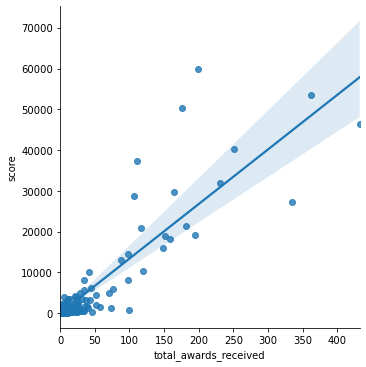

In [326]:
'''
Plotting awards against score
'''

sns.lmplot( data = wsb_cleaned, x = "total_awards_received", y = "score")